<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/06_SVAR_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVAR 예측 백테스트 (R / Colab)

본 노트북은 **SVAR(Structural VAR)** 모형을 이용해 다음 4가지 평가/운영 방식을 수행합니다.

1) **Full-sample (final fit)**: 전체 표본 적합 → 미래 *h* 스텝 예측 (평가용 X)
2) **Fixed-origin (holdout)**: 학습(80%) 한 번 적합 → 테스트 전 구간 한 번에 예측 (계수 고정)
3) **Rolling-origin + Rolling window**: 고정 길이 *W* 창으로 매 스텝 재적합 → 1-step 예측
4) **Rolling-origin + Expanding window**: 누적 창으로 매 스텝 재적합 → 1-step 예측

※ SVAR은 동시제(동시 상관) 구조를 식별하기 위한 제약(여기서는 재귀식, Cholesky-형)을 부여합니다.
예측(조건부 평균) 자체는 **동일한 축약형(VAR)** 과 같으므로, `vars::SVAR()`로 식별 후 **예측은 내부 VAR부분**으로 수행합니다.

In [1]:
# ===========================
# 0) 패키지 준비 & 옵션
# ===========================
pkgs <- c("quantmod", "vars", "zoo", "xts", "ggplot2", "dplyr", "tibble")
suppressWarnings(suppressMessages(
  for (p in pkgs) if (!requireNamespace(p, quietly = TRUE)) install.packages(p, quiet = TRUE, repos = "https://cloud.r-project.org")
))
lapply(pkgs, require, character.only = TRUE)

options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)
options(stringsAsFactors = FALSE)

Loading required package: quantmod

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: vars

Loading required package: MASS

Loading required package: strucchange

Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest

Loading required package: ggplot2

Loading required package: dplyr


######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.              

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

In [4]:
library(quantmod)

# ===========================
# 1) 데이터 로드 (TSLA, SPY) & 로그수익률(%)
# ===========================
symbol_y <- "TSLA"
symbol_x <- "SPY"
start_date <- "2022-01-01"
end_date   <- "2024-01-01"

# 심볼을 환경에 자동 할당하지 않고 반환받아 쓰면 더 안전합니다.
x_y <- suppressWarnings(getSymbols(Symbols = symbol_y, src = "yahoo",
                                  from = start_date, to = end_date,
                                  auto.assign = FALSE))
x_x <- suppressWarnings(getSymbols(Symbols = symbol_x, src = "yahoo",
                                  from = start_date, to = end_date,
                                  auto.assign = FALSE))

# 가격 열 추출: Adjusted 있으면 Ad(), 없으면 Cl()
get_price_col <- function(x) {
  if (any(grepl("\\.Adjusted$", colnames(x)))) {
    return(Ad(x))  # 조정종가
  } else if (any(grepl("\\.Close$", colnames(x)))) {
    return(Cl(x))  # 종가
  } else {
    stop("No Adjusted or Close column found.")
  }
}

px_y <- get_price_col(x_y)
px_x <- get_price_col(x_x)

# 공통 날짜로 병합 (inner join)
px <- na.omit(merge(px_y, px_x, join = "inner"))

# 보기 좋은 이름으로 교체
colnames(px) <- c(paste0("Close_", symbol_y), paste0("Close_", symbol_x))

# 로그수익률(%) - 정상성 고려
ret <- na.omit(diff(log(px))) * 100
colnames(ret) <- c(paste0("ret_", symbol_y), paste0("ret_", symbol_x))

dates <- index(ret)
cat(sprintf("%s/%s: %d returns | %s ~ %s\n",
            symbol_y, symbol_x, NROW(ret), as.Date(dates[1]), as.Date(dates[NROW(ret)])))

# TSLA 가격 백업 (수익률→가격 복원용)
price_y <- px[, 1]  # "Close_TSLA"


TSLA/SPY: 500 returns | 2022-01-04 ~ 2023-12-29


In [5]:
# ===========================
# 2) 학습/테스트 분할 (80/20)
# ===========================
n <- NROW(ret)
train_size <- floor(n * 0.8)
ret_train <- ret[1:train_size, ]
ret_test  <- ret[(train_size + 1):n, ]
dates_train <- index(ret_train)
dates_test  <- index(ret_test)

price_train_y <- price_y[index(price_y) <= dates_train[length(dates_train)]]
price_test_y  <- price_y[index(price_y) >= dates_test[1]]

cat(sprintf("train=%d, test=%d\n", NROW(ret_train), NROW(ret_test)))

train=400, test=100


In [6]:
# ===========================
# 3) 유틸 함수
# ===========================
rmse <- function(a, b) sqrt(mean((as.numeric(a) - as.numeric(b))^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(as.numeric(a) - as.numeric(b)), na.rm = TRUE)
r2   <- function(a, b) {
  a <- as.numeric(a); b <- as.numeric(b)
  1 - sum((a - b)^2, na.rm = TRUE) / sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
}

to_price_path <- function(p0, returns_pct) {
  p <- numeric(length(returns_pct))
  prev <- as.numeric(p0)
  for (i in seq_along(returns_pct)) {
    prev <- prev * exp(as.numeric(returns_pct[i]) / 100)
    p[i] <- prev
  }
  p
}

select_var_lag <- function(y_xts, maxlags = 5, ic = c("AIC", "BIC")[1]) {
  y_df <- as.data.frame(y_xts)
  colnames(y_df) <- colnames(y_xts)
  sel <- try(vars::VARselect(y_df, lag.max = maxlags, type = "const"), silent = TRUE)
  if (inherits(sel, "try-error")) return(1L)
  lag <- switch(toupper(ic),
                "AIC" = sel$selection[["AIC(n)"]],
                "BIC" = sel$selection[["SC(n)"]],
                1L)
  if (is.na(lag) || !is.finite(lag)) lag <- 1L
  as.integer(lag)
}

make_A_recursive <- function(k) {
  A <- diag(1, k)
  # 상삼각 0
  for (i in 1:k) for (j in (i+1):k) if (j <= k) A[i, j] <- 0
  # 하삼각 NA (추정 대상)
  for (i in 2:k) for (j in 1:(i-1)) A[i, j] <- NA
  A
}

fit_svar_safe <- function(y_xts, lags) {
  y_df <- as.data.frame(y_xts)
  colnames(y_df) <- colnames(y_xts)
  # 축약형 VAR
  varfit <- try(vars::VAR(y_df, p = lags, type = "const"), silent = TRUE)
  if (inherits(varfit, "try-error")) return(NULL)
  # 재귀식(A) 식별 SVAR
  A <- make_A_recursive(ncol(y_df))
  svarfit <- try(vars::SVAR(varfit, Amat = A, hessian = FALSE), silent = TRUE)
  if (inherits(svarfit, "try-error")) return(list(varfit = varfit, svarfit = NULL))
  list(varfit = varfit, svarfit = svarfit)
}

# VAR 예측 평균만 추출
var_predict_mean <- function(varfit, n.ahead = 1L) {
  pr <- vars::predict(varfit, n.ahead = n.ahead)
  # 각 변수별 fcst 첫번째 컬럼(평균)을 뽑아 matrix로 정리
  nm <- names(pr$fcst)
  out <- sapply(nm, function(v) pr$fcst[[v]][, 1])
  if (is.null(dim(out))) out <- matrix(out, ncol = length(nm))
  colnames(out) <- nm
  out
}

# 1-step ahead 예측 → 벡터
one_step_forecast <- function(y_xts, lags_min = 1L, lags_max = 5L) {
  # 안전장치: 샘플이 너무 짧으면 0% 수익률
  if (NROW(y_xts) <= lags_min) return(rep(0, NCOL(y_xts)))
  lags <- min(lags_max, max(lags_min, select_var_lag(y_xts, maxlags = lags_max, ic = "AIC")))
  fit <- fit_svar_safe(y_xts, lags)
  if (is.null(fit)) return(rep(0, NCOL(y_xts)))
  tryCatch({
    pred <- var_predict_mean(fit$varfit, n.ahead = 1L)
    as.numeric(pred[1, ])
  }, error = function(e) rep(0, NCOL(y_xts)))
}

In [7]:
# ===========================
# 4) 하이퍼파라미터
# ===========================
MAX_LAG <- 5L    # lag 탐색 상한 (보수적으로)
W       <- 120L  # Rolling 창 길이
stride  <- 10L   # stride마다 lag 재선택
h       <- 20L   # Full-sample 미래 예측 스텝(리포트용)

[Full] lag=4, SVAR fitted (forecast via VAR part)


Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


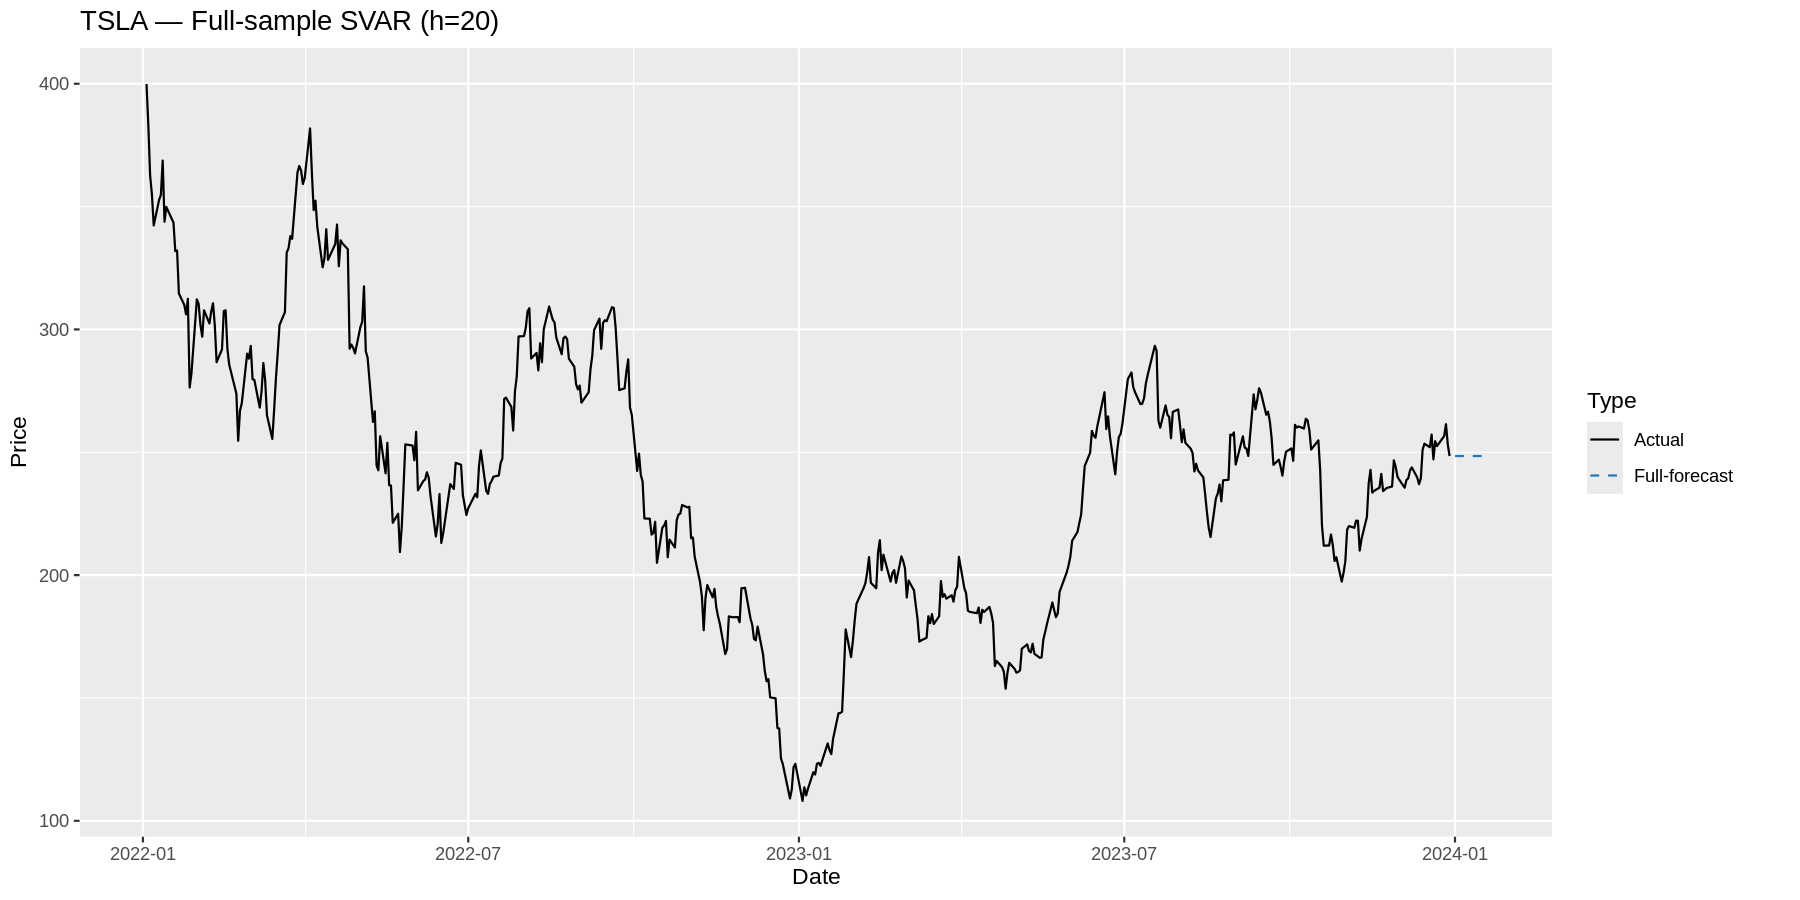

In [8]:
# ===========================
# A) Full-sample (final fit)
# ===========================
lag_full <- select_var_lag(ret, maxlags = MAX_LAG, ic = "AIC")
fit_full <- fit_svar_safe(ret, lag_full)
cat(sprintf("[Full] lag=%d, SVAR fitted (forecast via VAR part)\n", lag_full))

# 미래 h-step 수익률 예측
fcst_full_mat <- try(var_predict_mean(fit_full$varfit, n.ahead = h), silent = TRUE)
if (inherits(fcst_full_mat, "try-error")) {
  fcst_full_mat <- matrix(0, nrow = h, ncol = NCOL(ret))
  colnames(fcst_full_mat) <- colnames(ret)
}
# TSLA 수익률 열명
col_tsla <- paste0("ret_", symbol_y)
rhat_full <- fcst_full_mat[, col_tsla]

# 가격 경로 복원
p0_last <- as.numeric(last(price_y))
px_full <- to_price_path(p0_last, rhat_full)
future_dates <- seq(from = as.Date(index(price_y)[NROW(price_y)]) + 1, by = "day", length.out = h)
future_dates <- future_dates[weekdays(future_dates) %in% c("Monday","Tuesday","Wednesday","Thursday","Friday")]

df_full <- tibble::tibble(Date = c(as.Date(index(price_y)), future_dates[1:length(px_full)]),
                          Price = c(as.numeric(price_y), px_full),
                          Type  = c(rep("Actual", NROW(price_y)), rep("Full-forecast", length(px_full))))

ggplot(df_full, aes(Date, Price, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c("Actual" = "black", "Full-forecast" = "#1F77B4")) +
  scale_linetype_manual(values = c("Actual" = "solid", "Full-forecast" = "dashed")) +
  labs(title = sprintf("%s — Full-sample SVAR (h=%d)", symbol_y, h),
       x = "Date", y = "Price")

[Fixed-origin] lag=2, SVAR fitted (forecast via VAR part)
[Fixed-origin] RMSE=19.2942 | MAE=14.8699 | R2=-0.2166


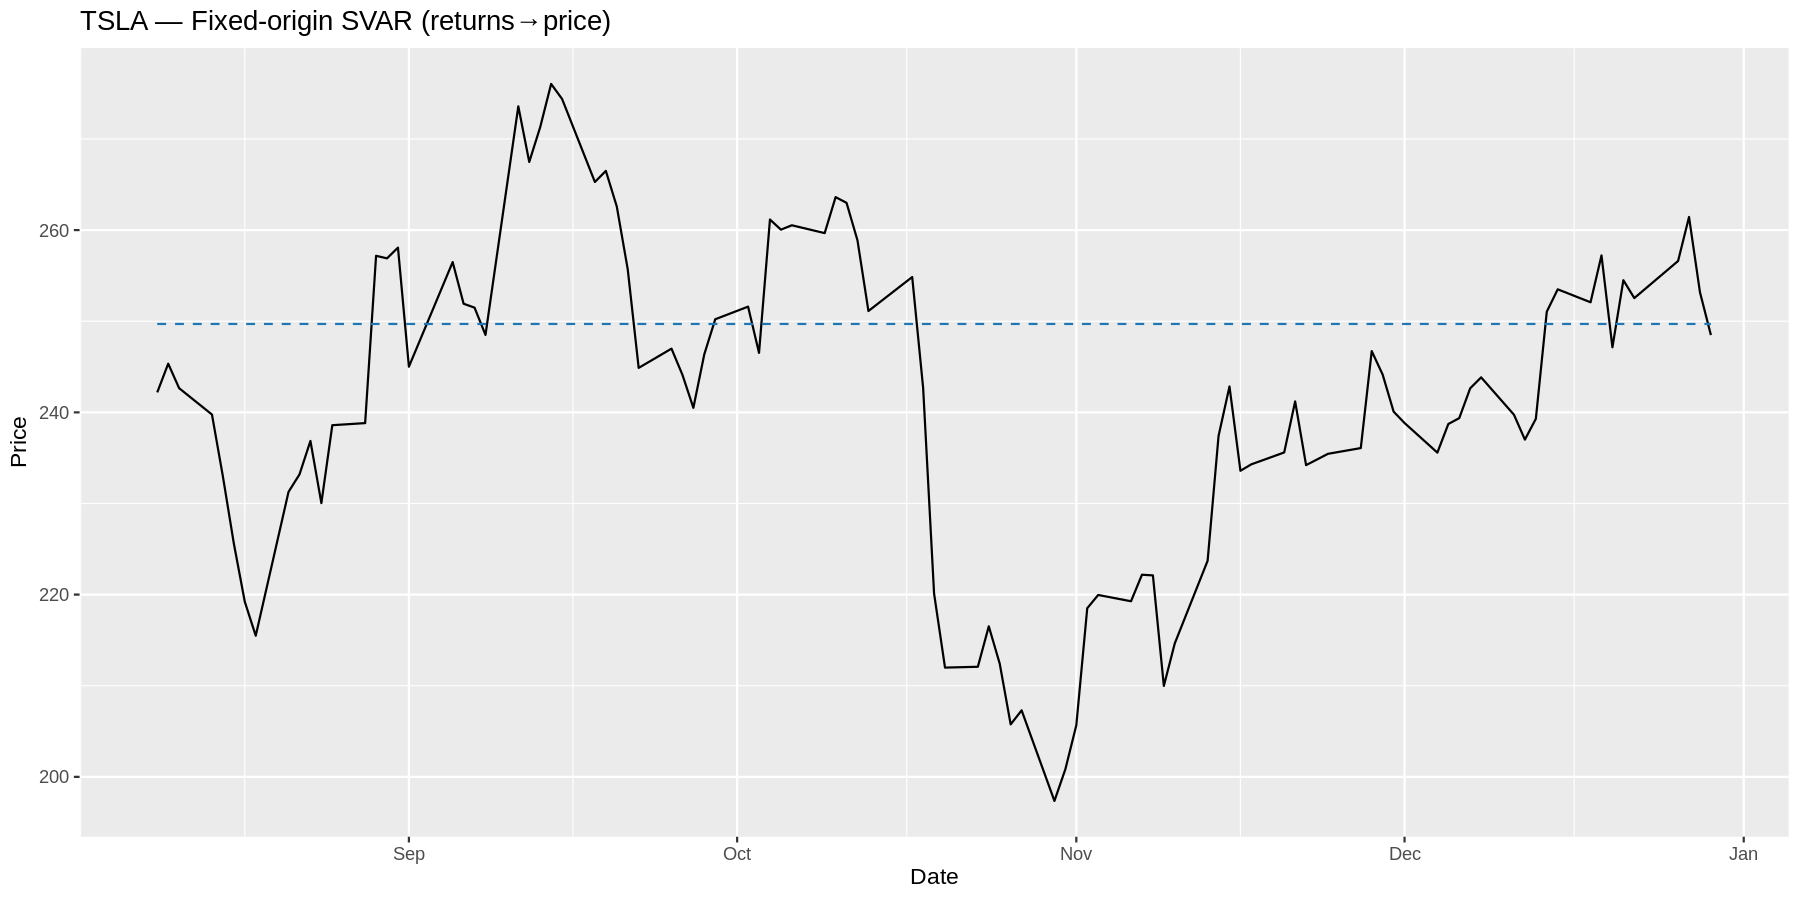

In [9]:
# ===========================
# B) Fixed-origin (holdout)
# ===========================
lag_fix <- select_var_lag(ret_train, maxlags = MAX_LAG, ic = "AIC")
fit_fix <- fit_svar_safe(ret_train, lag_fix)
cat(sprintf("[Fixed-origin] lag=%d, SVAR fitted (forecast via VAR part)\n", lag_fix))

# 테스트 전구간 동시 예측
n_test <- NROW(ret_test)
fcst_fix_mat <- try(var_predict_mean(fit_fix$varfit, n.ahead = n_test), silent = TRUE)
if (inherits(fcst_fix_mat, "try-error")) {
  fcst_fix_mat <- matrix(0, nrow = n_test, ncol = NCOL(ret))
  colnames(fcst_fix_mat) <- colnames(ret)
}
rhat_fix <- fcst_fix_mat[, paste0("ret_", symbol_y)]

p0_test <- as.numeric(last(price_train_y))
pred_fix_price <- to_price_path(p0_test, rhat_fix)

actual_test_price <- as.numeric(price_test_y)
dates_test_price  <- as.Date(index(price_test_y))

rmse_fix <- rmse(actual_test_price, pred_fix_price)
mae_fix  <- mae(actual_test_price, pred_fix_price)
r2_fix   <- r2 (actual_test_price, pred_fix_price)
cat(sprintf("[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_fix, mae_fix, r2_fix))

df_fix <- tibble::tibble(Date = dates_test_price,
                         Actual = actual_test_price,
                         Pred   = pred_fix_price)

ggplot(df_fix, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),    color = "#1F77B4", linetype = "dashed") +
  labs(title = sprintf("%s — Fixed-origin SVAR (returns→price)", symbol_y),
       x = "Date", y = "Price")

[Rolling window] RMSE=19.2942 | MAE=14.8699 | R2=-0.2166


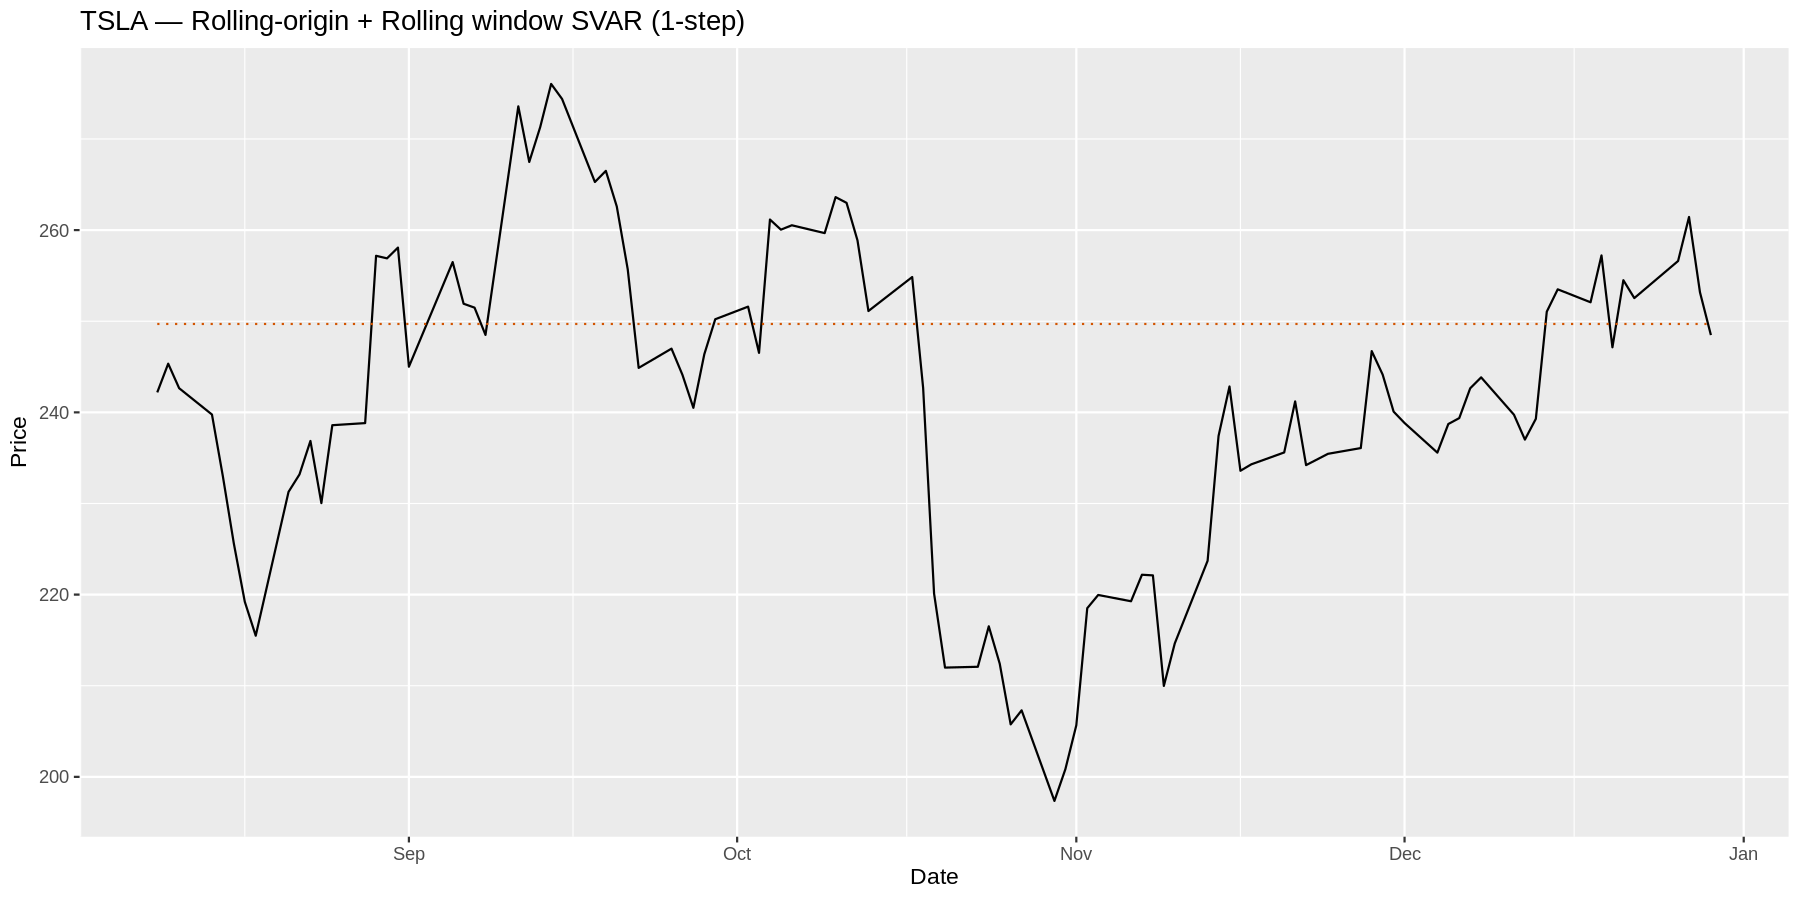

In [10]:
# ===========================
# C) Rolling-origin + Rolling window
# ===========================
hist <- ret_train
n_test <- NROW(ret_test)
pred_roll_ret <- matrix(NA_real_, nrow = n_test, ncol = NCOL(ret))
colnames(pred_roll_ret) <- colnames(ret)

# 초기 lag
lag_curr <- select_var_lag(if (NROW(hist) > W) hist[(NROW(hist)-W+1):NROW(hist), ] else hist,
                           maxlags = MAX_LAG, ic = "AIC")

for (i in seq_len(n_test)) {
  y_win <- if (NROW(hist) > W) hist[(NROW(hist)-W+1):NROW(hist), ] else hist
  if (stride > 0 && ((i - 1) %% stride) == 0) {
    lag_curr <- select_var_lag(y_win, maxlags = MAX_LAG, ic = "AIC")
  }
  fit <- fit_svar_safe(y_win, lag_curr)
  if (is.null(fit)) {
    pred <- rep(0, NCOL(ret))  # naive
  } else {
    pred <- tryCatch({
      as.numeric(var_predict_mean(fit$varfit, n.ahead = 1)[1, ])
    }, error = function(e) rep(0, NCOL(ret)))
  }
  pred_roll_ret[i, ] <- pred
  # 워크-포워드(실제값 주입)
  hist <- rbind(hist, ret_test[i, ])
}

pred_roll_price <- to_price_path(as.numeric(last(price_train_y)), pred_roll_ret[, paste0("ret_", symbol_y)])

rmse_r <- rmse(actual_test_price, pred_roll_price)
mae_r  <- mae(actual_test_price, pred_roll_price)
r2_r   <- r2 (actual_test_price, pred_roll_price)
cat(sprintf("[Rolling window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_r, mae_r, r2_r))

df_roll <- tibble::tibble(Date = dates_test_price,
                          Actual = actual_test_price,
                          Pred   = pred_roll_price)

ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),    color = "#D35400", linetype = "dotted") +
  labs(title = sprintf("%s — Rolling-origin + Rolling window SVAR (1-step)", symbol_y),
       x = "Date", y = "Price")

[Expanding window] RMSE=19.2942 | MAE=14.8699 | R2=-0.2166
# A tibble: 3 × 4
  Method            RMSE   MAE     R2
  <chr>            <dbl> <dbl>  <dbl>
1 Fixed-origin      19.3  14.9 -0.217
2 Rolling window    19.3  14.9 -0.217
3 Expanding window  19.3  14.9 -0.217


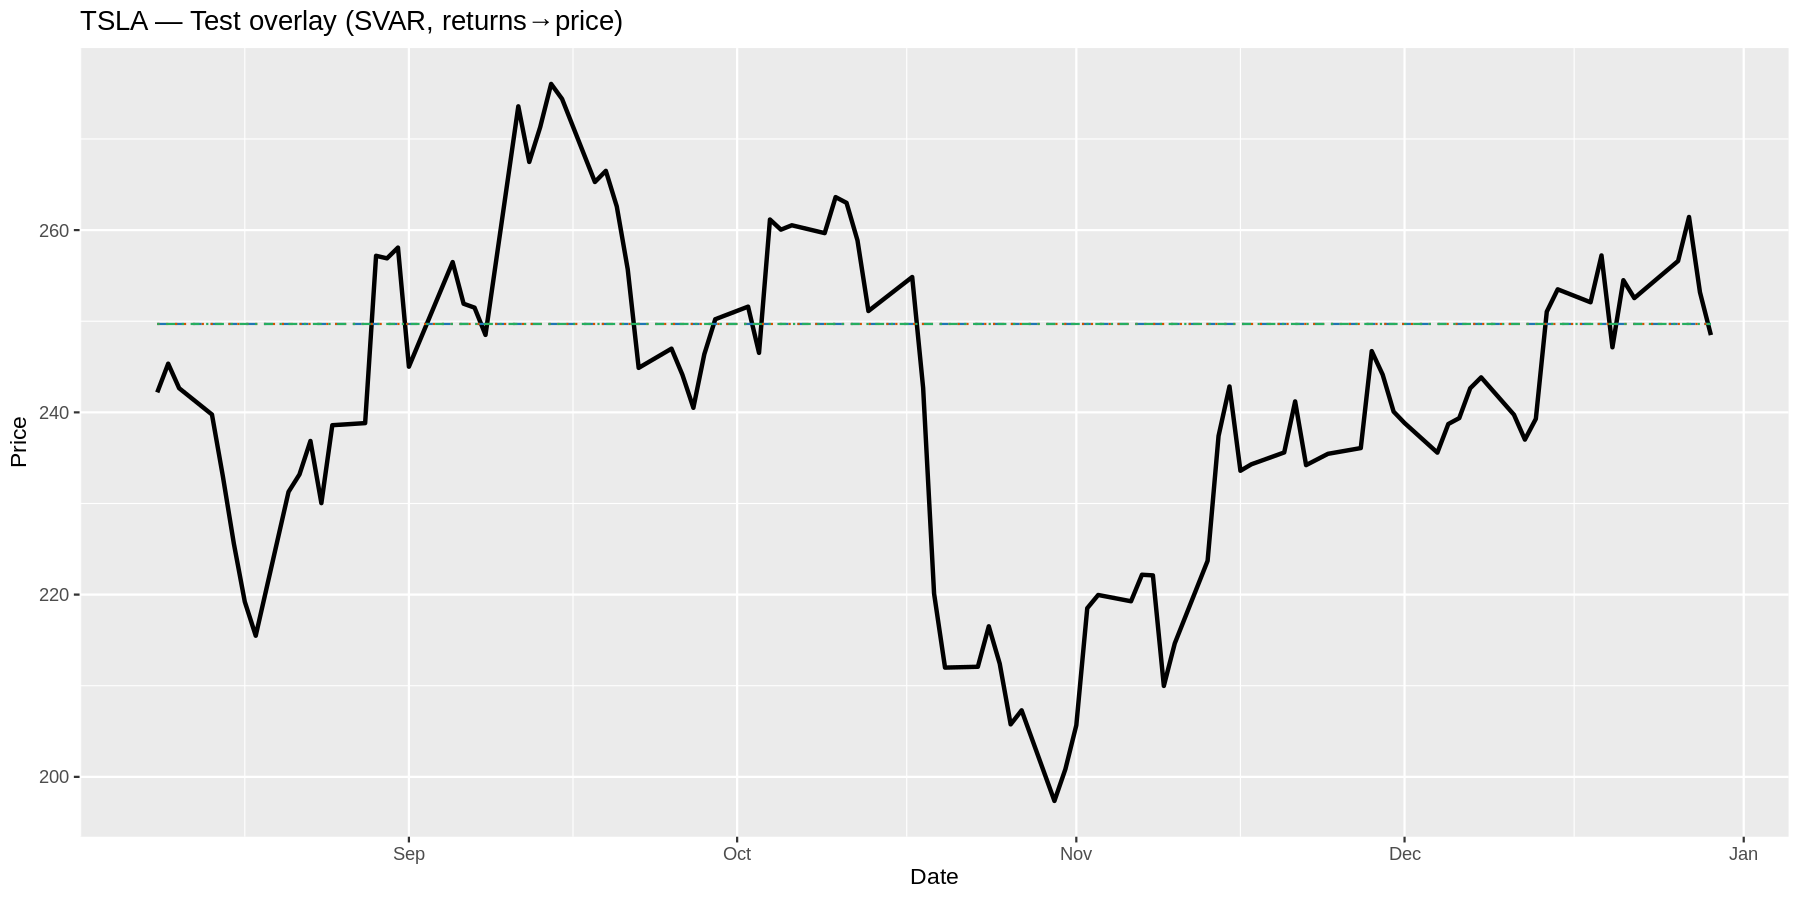

In [11]:
# ===========================
# D) Rolling-origin + Expanding window
# ===========================
hist <- ret_train
pred_exp_ret <- matrix(NA_real_, nrow = n_test, ncol = NCOL(ret))
colnames(pred_exp_ret) <- colnames(ret)

lag_curr <- select_var_lag(hist, maxlags = MAX_LAG, ic = "AIC")

for (i in seq_len(n_test)) {
  if (stride > 0 && ((i - 1) %% stride) == 0) {
    lag_curr <- select_var_lag(hist, maxlags = MAX_LAG, ic = "AIC")
  }
  fit <- fit_svar_safe(hist, lag_curr)
  if (is.null(fit)) {
    pred <- rep(0, NCOL(ret))
  } else {
    pred <- tryCatch({
      as.numeric(var_predict_mean(fit$varfit, n.ahead = 1)[1, ])
    }, error = function(e) rep(0, NCOL(ret)))
  }
  pred_exp_ret[i, ] <- pred
  hist <- rbind(hist, ret_test[i, ])
}

pred_exp_price <- to_price_path(as.numeric(last(price_train_y)), pred_exp_ret[, paste0("ret_", symbol_y)])

rmse_e <- rmse(actual_test_price, pred_exp_price)
mae_e  <- mae(actual_test_price, pred_exp_price)
r2_e   <- r2 (actual_test_price, pred_exp_price)
cat(sprintf("[Expanding window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_e, mae_e, r2_e))

# 요약 & 오버레이
summary_tbl <- tibble::tibble(
  Method = c("Fixed-origin", "Rolling window", "Expanding window"),
  RMSE   = c(rmse_fix, rmse_r, rmse_e),
  MAE    = c(mae_fix,  mae_r,  mae_e),
  R2     = c(r2_fix,   r2_r,   r2_e)
) %>% arrange(RMSE)

print(summary_tbl)

ggplot() +
  geom_line(data = tibble(Date = dates_test_price, Price = actual_test_price),
            aes(Date, Price), color = "black", linewidth = 1) +
  geom_line(data = tibble(Date = dates_test_price, Price = pred_fix_price),
            aes(Date, Price), linetype = "dashed", color = "#1F77B4") +
  geom_line(data = tibble(Date = dates_test_price, Price = pred_roll_price),
            aes(Date, Price), linetype = "dotted", color = "#D35400") +
  geom_line(data = tibble(Date = dates_test_price, Price = pred_exp_price),
            aes(Date, Price), linetype = "dotdash", color = "#27AE60") +
  labs(title = sprintf("%s — Test overlay (SVAR, returns→price)", symbol_y),
       x = "Date", y = "Price")